##### DL code basic

Dataset, Model, Train 코드 틀.

In [ ]:
### Loading famous datasets

# 파이썬 커널 로드 중 디랙토리에 한국어가 있으면 인코딩 안될 수도. (Window 기본 인코딩이 cp949). 에러 뜨면 cmd : setx PYTHONUTF8 1 실행 후 재시작
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

tf.__version__

c:\Users\xelle\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


'2.17.0'

In [20]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

60000
10000


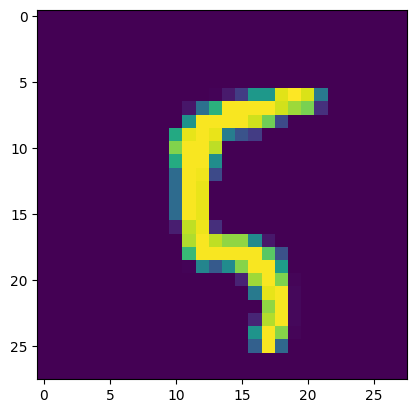

In [3]:
print(len(train_images))
print(len(test_images))
plt.imshow(train_images[100])

In [ ]:
'''
Conv2D layer는 4차원 입력 (Batch_sz, height, width, channel)을 기대함.
현재 (None, 28, 28)이므로 channel 차원 1을 추가해주자. (batch로 나누긴 할 것이지만 모델 정의 단계에서는 None으로 표기한다.)
따라서 conv를 통과할 images들만 차원 확장.
'''

train_images = train_images[..., tf.newaxis] 
test_images = test_images[..., tf.newaxis]

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000).batch(1000) #(train_images, train_labels)를 묶은 데이터셋 생성. batch_sz 1000으로 묶기.

testset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(1000)

'''
train_ = tf.cast(train_images, dtype=tf.float32)
train_ = tf.expand_dims(train_, axis = -1)

dataset = tf.data.Dataset.from_tensor_slices((train_, train_labels)).batch(1000)
'''

In [19]:
print(train_images.shape)

(60000, 28, 28, 1, 1, 1)


In [37]:
# 모델 선언법
# MNIST : 28 by 28

def create_model(model_type: str):
    # 1. 모델 선언 : keras (tensorflow)
    ### 1.1. tf.keras.Sequential() : .add로 layer 쌓기
    if model_type.lower() == 'sequential':
        model = tf.keras.Sequential() 
        model.add(tf.keras.layers.Conv2D(32, 2, strides = (1, 1), padding = 'same')) # 32 kernels, kernel_size : 2, 입력과 같은 크기가 되도록 padding.
        model.add(tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')) # 2 by 2 pooling, 입력과 같은 크기가 되도록 padding.
        model.add(tf.keras.layers.Conv2D(16, 2, strides = (1, 1), padding = 'same')) 
        model.add(tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same'))
        model.add(tf.keras.layers.Conv2D(8, 2, strides = (1, 1), padding = 'same')) 
        model.add(tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same'))
        model.add(tf.keras.layers.Flatten()) # 다차원 입력을 1차원 배열로 : batch_size * x * y -> batch_size * xy. 주로 conv layer 뒤 FC layer에 연결할 때 사용.
        model.add(tf.keras.layers.Dense(30, activation = 'relu')) # 30개 neuron의 FC layer. activation X.    벡터 차원 : batch_size * 30 
        model.add(tf.keras.layers.Dropout(0.2)) # 20% dropout. Dense(30)에서 Dense(10)으로 가는 간선에 dropout.
        model.add(tf.keras.layers.Dense(10, activation='softmax')) # 10개 neuron의 FC layer, 각각 softmax activation.   벡터 차원 : batch_size * 10

        model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']) # 학습 세팅.
        return model

    ### 1.2. tf.keras.Input으로 입출력 정의.
    elif model_type.lower() == 'functional':
        input = tf.keras.Input(shape=(28, 28, 1))
        x = tf.keras.layers.Conv2D(16, 2, strides = (1, 1), padding = 'same') (input) 
        x = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same') (x)
        x = tf.keras.layers.Flatten() (x)
        x = tf.keras.layers.Dense(32) (x)
        x = tf.keras.layers.Dense(10, activation= 'softmax') (x)

        model = tf.keras.Model(input, x) # input이 모델 입력, x가 모델 출력. 

        model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        return model

    ### 1.3. tf.keras.Model 상속
    ### call()을 직접 구성하여 자유도가 높아 ResNet 등 구현에 용이.
    elif model_type.lower() == 'keras-class':
        class CNNModel(tf.keras.Model):
            def __init__(self, rate = 0.1):
                super(CNNModel, self).__init__()
                self.conv = tf.keras.layers.Conv2D(16, 2, strides = (1, 1), padding = 'same')
                self.pool = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')
                self.flat = tf.keras.layers.Flatten()
                self.dense = tf.keras.layers.Dense(32)
                self.final_layer = tf.keras.layers.Dense(10, activation = 'softmax')
                
            def call(self, inp): # keras에서 forward pass를 정의하는 함수. keras는 __call__을 자동 호출 : model(input) 호출 시 call(input) 실행.
                output = self.conv(inp) 
                output = self.pool(output)
                output = self.flat(output)
                output = self.dense(output)
                final_output = self.final_layer(output)
                return final_output
        
        model = CNNModel()
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return CNNModel()

    ### 1.4. PyTorch : PyTorch는 .fit() 대신 직접 loop를 돌리는 등 보다 복잡하므로 torch_basic.ipynb에서 소개.
    elif model_type.lower() == 'torch-class':
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
                self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
                self.conv2_drop = nn.Dropout2d()
                self.fc1 = nn.Linear(320, 50)
                self.fc2 = nn.Linear(50, 10)

            def forward(self, x):
                x = F.relu(F.max_pool2d(self.conv1(x), 2))
                x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
                x = x.view(-1, 320)
                x = F.relu(self.fc1(x))
                x = F.dropout(x, training=self.training)
                x = self.fc2(x)
                return x
            
        return Net()

In [22]:
model_type = 'sequential'  # 원하는 모델 선택: 'sequential', 'functional', 'keras-class', 'torch-class'

model = create_model(model_type)

model.fit(dataset, epochs=10, validation_data=testset)

Epoch 1/10


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1463 - loss: 12.1650 - val_accuracy: 0.3192 - val_loss: 1.9294
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3037 - loss: 1.9382 - val_accuracy: 0.4765 - val_loss: 1.5275
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4302 - loss: 1.6215 - val_accuracy: 0.5887 - val_loss: 1.2047
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5063 - loss: 1.3662 - val_accuracy: 0.6771 - val_loss: 0.9703
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5756 - loss: 1.1745 - val_accuracy: 0.7355 - val_loss: 0.8080
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6337 - loss: 1.0320 - val_accuracy: 0.7850 - val_loss: 0.6757
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6906 - loss: 0.8878 - val_accuracy: 0.8514 - val_loss: 0.4962
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7607 - loss: 0.7171 - val_accuracy: 0.8880 - val_loss: 0

## 2. Training Model

In [23]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         3,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,774 (81.15 KB)

 Trainable params: 6,924 (27.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,850 (54.11 KB)

## 3. Evaluation

In [24]:
model.evaluate(testset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9080 - loss: 0.3120


[0.27411961555480957, 0.9211000204086304]

In [27]:
test_images[2].shape

(28, 28, 1)

In [28]:
## 예시 출력

test = tf.expand_dims(test_images[2], 0) # test_images는 batch축이 있지만 test_images[2]는 batch 축이 없으므로 0번째 index에 차원 추가.
result = model(test) # 마지막에 Dense(10) 이므로 출력은 (batch_sz, 10).
result = tf.argmax(result, axis = -1) # 가장 큰 값의 index를 반환.

print(result)

tf.Tensor([1], shape=(1,), dtype=int64)


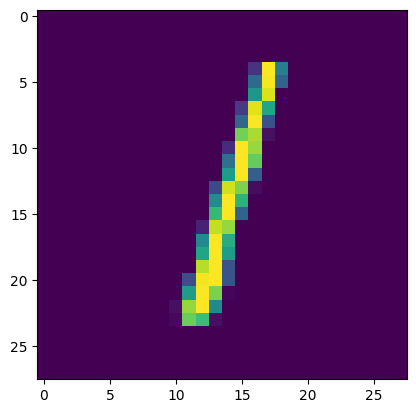

In [29]:
plt.imshow(test_images[2])

In [31]:
model_type = 'functional'  # 원하는 모델 선택: 'sequential', 'functional', 'keras-class', 'torch-class'

model = create_model(model_type)

model.fit(dataset, epochs=10, validation_data=testset)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6108 - loss: 19.5314 - val_accuracy: 0.9090 - val_loss: 2.2040
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9107 - loss: 1.9040 - val_accuracy: 0.9190 - val_loss: 1.3619
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9296 - loss: 1.0407 - val_accuracy: 0.9321 - val_loss: 0.9099
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9413 - loss: 0.6952 - val_accuracy: 0.9364 - val_loss: 0.7673
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9509 - loss: 0.4842 - val_accuracy: 0.9335 - val_loss: 0.7793
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9540 - loss: 0.4045 - val_accuracy: 0.9379 - val_loss: 0.6563
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9580 - loss: 0.3337 - val_accuracy: 0.9453 - val_loss: 0.5501
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9606 - loss: 0.2939 - val_accuracy: 0.9458 - 

In [40]:
inp = test_images[0]
inp = tf.expand_dims(inp, 0)

res = model(inp)

In [43]:
print(np.argmax(res))

7


In [44]:
print(test_labels[0])

7
